# Going Deeper 04. Data Augmentation
--------
## [루브릭]

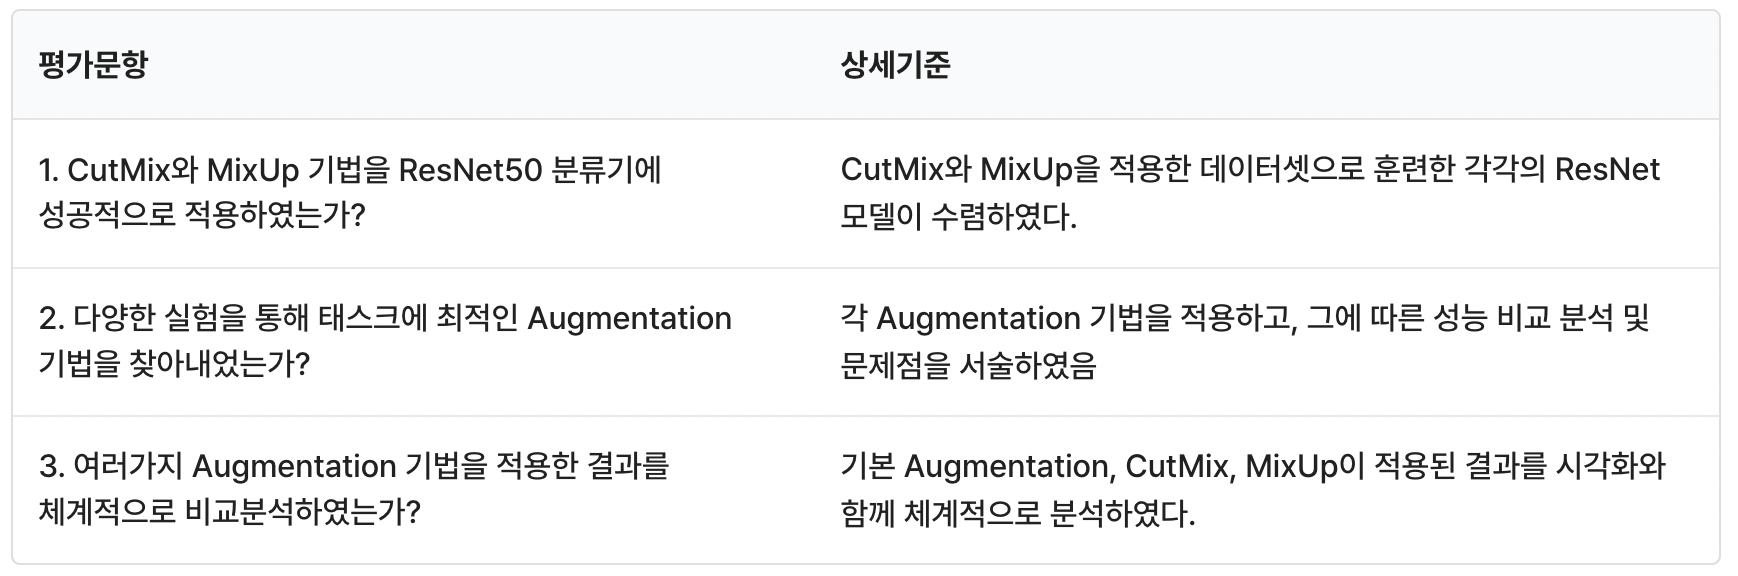

## Step 1 ResNet50 분류기로 Stanford Dogs 데이터 셋 분류해 보기

앞선 프로젝트에서 만들었던 ResNet50 모델을 활용하여 Augmentation 없이 Stanford Dogs 데이터 셋을 먼저 분류해 보겠습니다.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import pandas as pd

In [2]:
tf.keras.backend.clear_session()

In [3]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [5]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' ## 초기화할 GPU number

with tf.Graph().as_default():
	# GPU 메모리를 전부 할당하지 않고, 아주 적은 비율만 할당되어 시작됨. 프로세스의 메모리 수요에 따라 자동적으로 증가
	# 단, GPU 메모리를 처음부터 전체 비율을 사용하지 않음
	gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)

In [6]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [50]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})


In [51]:
ds_info.features["label"].num_classes

120

In [52]:
ds_info.features["label"].names

['n02085620-chihuahua',
 'n02085782-japanese_spaniel',
 'n02085936-maltese_dog',
 'n02086079-pekinese',
 'n02086240-shih-tzu',
 'n02086646-blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-rhodesian_ridgeback',
 'n02088094-afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-walker_hound',
 'n02089973-english_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-irish_wolfhound',
 'n02091032-italian_greyhound',
 'n02091134-whippet',
 'n02091244-ibizan_hound',
 'n02091467-norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-saluki',
 'n02092002-scottish_deerhound',
 'n02092339-weimaraner',
 'n02093256-staffordshire_bullterrier',
 'n02093428-american_staffordshire_terrier',
 'n02093647-bedlington_terrier',
 'n02093754-border_terrier',
 'n02093859-kerry_blue_terrier',
 'n02093991-irish_terrier',
 'n02094114-norfolk_terrier',
 'n02094258-norwi

In [58]:
sample = ds_train.take(1)
for example in sample:  
    print(example)

(<tf.Tensor: shape=(180, 160, 3), dtype=uint8, numpy=
array([[[133, 130, 113],
        [150, 149, 131],
        [184, 188, 171],
        ...,
        [ 65,  73,  75],
        [ 69,  77,  80],
        [ 73,  80,  86]],

       [[234, 231, 214],
        [215, 216, 198],
        [164, 168, 151],
        ...,
        [ 54,  62,  64],
        [ 55,  63,  66],
        [ 58,  65,  71]],

       [[157, 156, 138],
        [193, 194, 176],
        [145, 149, 132],
        ...,
        [ 59,  68,  67],
        [ 58,  66,  69],
        [ 60,  67,  73]],

       ...,

       [[ 94,  83,  77],
        [ 84,  73,  67],
        [ 75,  64,  58],
        ...,
        [156, 156, 156],
        [135, 135, 135],
        [123, 123, 123]],

       [[111, 100,  94],
        [ 71,  60,  54],
        [ 64,  53,  47],
        ...,
        [176, 176, 176],
        [153, 153, 153],
        [138, 138, 138]],

       [[ 87,  76,  70],
        [ 50,  39,  33],
        [ 44,  33,  27],
        ...,
        [180, 180, 1

총 class 갯수는 120개이며, 정수형으로 표시되어 있음을 확인할 수 있습니다.

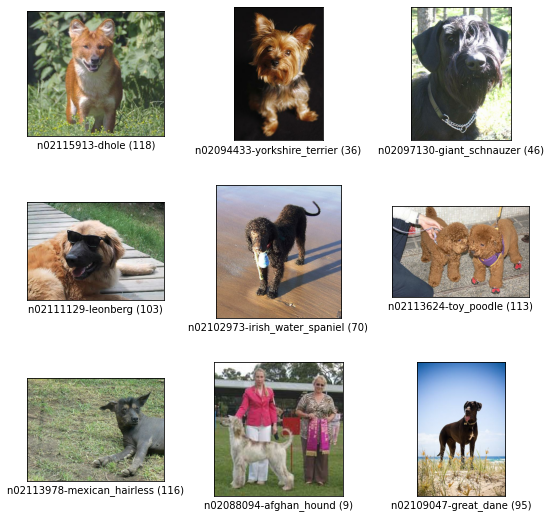

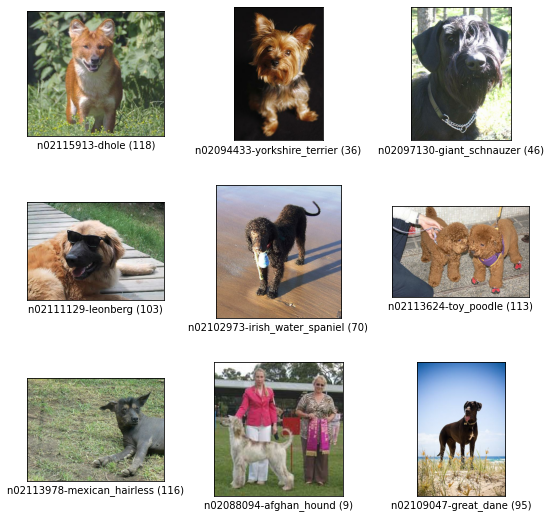

In [59]:
tfds.show_examples(ds_train, ds_info)

In [60]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(12000, shape=(), dtype=int64)
tf.Tensor(8580, shape=(), dtype=int64)


In [18]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [19]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [20]:
ds_train_norm = apply_normalize_on_dataset(ds_train)

In [10]:
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add

In [65]:
# is_50 : True => resnet_50
# is_plain : True => no skip connection
# original skip connection
def build_resnet_block(input_layer, num_cnn=3, channel=64, block_num=0, is_50=False, is_plain=False):
    # 입력 레이어
    x = input_layer
    
    # CNN 레이어
    if not is_50:
        for cnn_num in range(num_cnn):
            shortcut = x
            if (block_num != 0) and (cnn_num == 0):
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    strides=(2,2),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'block{block_num}_0_conv{cnn_num}')(x)

            else:
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    strides=(1,1),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'block{block_num}_0_conv{cnn_num}')(x)  

            x = keras.layers.BatchNormalization(name=f'block{block_num}_0_bn{cnn_num}')(x)
            x = keras.layers.Activation('relu', name=f'block{block_num}_0_relu{cnn_num}')(x)
            
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}')(x)
            x = keras.layers.BatchNormalization(name=f'block{block_num}_1_bn{cnn_num}')(x)
            
            if not is_plain:
                shortcut_channel = shortcut.shape.as_list()[-1]
                
                if (shortcut_channel != channel) and (block_num == 0) and (cnn_num == 0):
                    shortcut = keras.layers.Conv2D(channel, kernel_size=(1,1), strides=(1,1), padding='valid', name=f'block{block_num}_3_shortcut{cnn_num}')(shortcut)
                    shortcut = keras.layers.BatchNormalization(name=f'block{block_num}_2_bn{cnn_num}')(shortcut)                    
                    
                elif (shortcut_channel != channel) and (block_num != 0) and (cnn_num == 0):    
                    shortcut = keras.layers.Conv2D(channel, kernel_size=(1,1), strides=(2,2), padding='valid', name=f'block{block_num}_3_shortcut{cnn_num}')(shortcut)
                    shortcut = keras.layers.BatchNormalization(name=f'block{block_num}_2_bn{cnn_num}')(shortcut)                    
                    
                    
                # skip connection
                x = keras.layers.Add(name=f'block{block_num}_2_add{cnn_num}')([x, shortcut])
                x = keras.layers.Activation('relu', name=f'block{block_num}_2_relu{cnn_num}')(x)
            
            else:
                x = keras.layers.Activation('relu', name=f'block{block_num}_2_relu{cnn_num}')(x)
    
    else :
        for cnn_num in range(num_cnn):
            shortcut = x
            if (block_num != 0) and (cnn_num == 0):
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(1,1),
                    strides=(2,2),
                    kernel_initializer='he_normal',
                    padding='valid',
                    name=f'block{block_num}_0_conv{cnn_num}')(x)

            else:
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(1,1),
                    strides=(1,1),
                    kernel_initializer='he_normal',
                    padding='valid',
                    name=f'block{block_num}_0_conv{cnn_num}')(x)  
 
            x = keras.layers.BatchNormalization(name=f'block{block_num}_0_bn{cnn_num}')(x)
            x = keras.layers.Activation('relu', name=f'block{block_num}_0_relu{cnn_num}')(x)

            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}')(x)
            x = keras.layers.BatchNormalization(name=f'block{block_num}_1_bn{cnn_num}')(x)
            x = keras.layers.Activation('relu', name=f'block{block_num}_1_relu{cnn_num}')(x)

            x = keras.layers.Conv2D(
                filters=channel*4,
                kernel_size=(1,1),
                kernel_initializer='he_normal',
                padding='valid',
                name=f'block{block_num}_2_conv{cnn_num}')(x)
            x = keras.layers.BatchNormalization(name=f'block{block_num}_2_bn{cnn_num}')(x)        

            if not is_plain:
                shortcut_channel = shortcut.shape.as_list()[-1]

                if (shortcut_channel != channel*4) and (block_num == 0) and (cnn_num == 0):
                    shortcut = keras.layers.Conv2D(channel*4, kernel_size=(1,1), strides=(1,1), padding='valid', name=f'block{block_num}_3_shortcut{cnn_num}')(shortcut)
                    shortcut = keras.layers.BatchNormalization(name=f'block{block_num}_3_bn{cnn_num}')(shortcut)                    
                    
                elif (shortcut_channel != channel*4) and (block_num != 0) and (cnn_num == 0):    
                    shortcut = keras.layers.Conv2D(channel*4, kernel_size=(1,1), strides=(2,2), padding='valid', name=f'block{block_num}_3_shortcut{cnn_num}')(shortcut)
                    shortcut = keras.layers.BatchNormalization(name=f'block{block_num}_3_bn{cnn_num}')(shortcut)

                # skip connection
                x = keras.layers.Add(name=f'block{block_num}_3_add{cnn_num}')([x, shortcut])
                x = keras.layers.Activation('relu', name=f'block{block_num}_3_relu{cnn_num}')(x)

            else :
                x = keras.layers.Activation('relu', name=f'block{block_num}_3_relu{cnn_num}')(x)
        
    return x

In [66]:
resnet_input_layer = keras.layers.Input(shape=(224,224,3))   # 입력 레이어 생성
res_block_output = build_resnet_block(resnet_input_layer)    # resnet block 생성

In [67]:
def build_resnet(input_shape=(224,224,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=120, is_50=False, is_plain=False):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # conv 1층
    output = keras.layers.Conv2D(filters=channel_list[0],
                                kernel_size=(7,7),
                                strides=(2,2),
                                padding='same',
                                kernel_initializer='he_normal')(output)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.Activation('relu')(output)
    
    # conv2_x pooling
    output = keras.layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(output)
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i, 
            is_50=is_50,
            is_plain=is_plain
        )
        
    output = keras.layers.GlobalAveragePooling2D()(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(512, activation='relu')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [68]:
resnet_50 = build_resnet(is_50=True)
resnet_50.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [44]:
# from tensorflow.keras.utils import plot_model

# plot_model(resnet_50, show_shapes=True, to_file='resnet_50.png')

In [7]:
BATCH_SIZE = 64
EPOCH = 30

In [8]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(
                                    learning_rate=0.001,
                                    beta_1=0.9,
                                    beta_2=0.999,
                                    epsilon=1e-07,
                                    name='Adam'),
    metrics=['accuracy'],)

history_50 = resnet_50.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

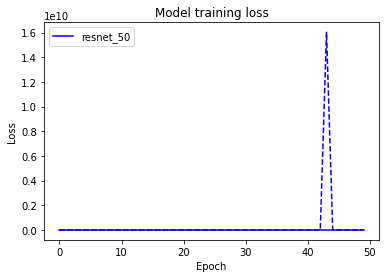

In [71]:
import matplotlib.pyplot as plt
plt.plot(history_50.history['loss'], 'b')
plt.plot(history_50.history['val_loss'], 'b--')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50'], loc='upper left')
plt.show()

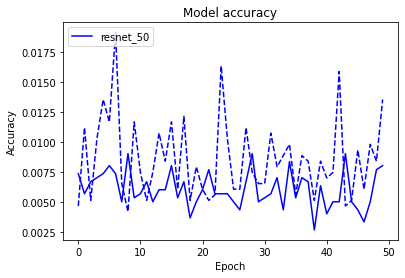

In [72]:
plt.plot(history_50.history['accuracy'], 'b')
plt.plot(history_50.history['val_accuracy'], 'b--')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50'], loc='upper left')
plt.show()

직접 구성한 resnet50으로 학습을 한 결과 여전히 학습이 잘 진행되지 못하고 있습니다. 단순히 데이터의 문제는 아니었던 것으로 판단되며 모델 구조는 다시 한번 뜯어보고 고칠 필요가 있을 것 같습니다.    
일단 augmentation 실험을 위해 keras에서 지원하는 resnet50 모델을 불러와서 테스트를 해보겠습니다.

In [25]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(120, activation='softmax')
])

In [9]:
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(
                                    learning_rate=0.001,
                                    beta_1=0.9,
                                    beta_2=0.999,
                                    epsilon=1e-07,
                                    name='Adam'),
    metrics=['accuracy'],)

history50 = resnet50.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

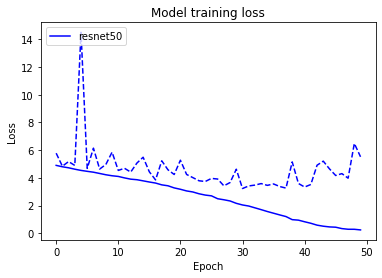

In [78]:
import matplotlib.pyplot as plt
plt.plot(history50.history['loss'], 'b')
plt.plot(history50.history['val_loss'], 'b--')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet50'], loc='upper left')
plt.show()

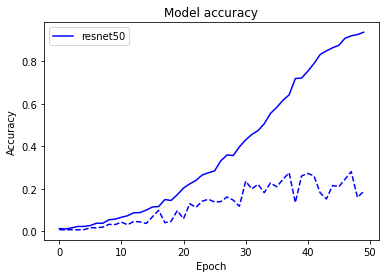

In [79]:
plt.plot(history50.history['accuracy'], 'b')
plt.plot(history50.history['val_accuracy'], 'b--')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet50'], loc='upper left')
plt.show()

데이터를 셔플했는데도 불구하고 training 데이터로는 학습이 진행되는 것으로 보이나, test 데이터의 결과는 여전히 좋지 않습니다. optimizer를 SGD로 변경해서 테스트를 추가로 진행해 보겠습니다. 

resnet50을 불러올 때 include_top (fc layer)을 포함하여 불러온 뒤 다시 테스트 해보도록 하겠습니다. 

In [10]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=True,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(120, activation='softmax')
])

102981632/102967424 [==============================] - 0s 0us/step


In [14]:
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(
                                    learning_rate=0.001,
                                    beta_1=0.9,
                                    beta_2=0.999,
                                    epsilon=1e-07,
                                    name='Adam'),
    metrics=['accuracy'],)

history50 = resnet50.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
187/187 [==============================] - 84s 231ms/step - loss: 4.7884 - accuracy: 0.0070 - val_loss: 4.7907 - val_accuracy: 0.0070
Epoch 2/50
187/187 [==============================] - 42s 225ms/step - loss: 4.7899 - accuracy: 0.0114 - val_loss: 4.7891 - val_accuracy: 0.0061
Epoch 3/50
187/187 [==============================] - 42s 223ms/step - loss: 4.7907 - accuracy: 0.0077 - val_loss: 4.7887 - val_accuracy: 0.0042
Epoch 4/50
187/187 [==============================] - 42s 224ms/step - loss: 4.7900 - accuracy: 0.0080 - val_loss: 4.7884 - val_accuracy: 0.0051
Epoch 5/50
187/187 [==============================] - 42s 222ms/step - loss: 4.7873 - accuracy: 0.0077 - val_loss: 4.7881 - val_accuracy: 0.0117
Epoch 6/50
187/187 [==============================] - 42s 223ms/step - loss: 4.7856 - accuracy: 0.0117 - val_loss: 4.7836 - val_accuracy: 0.0145
Epoch 7/50
187/187 [==============================] - 42s 222ms/step - loss: 4.7864 - accuracy: 0.0084 - val_loss: 4.7862 - val_ac

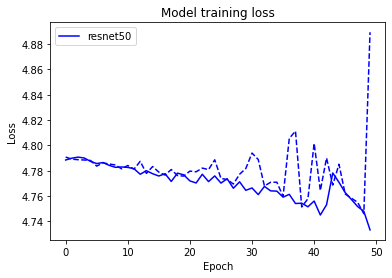

In [15]:
import matplotlib.pyplot as plt
plt.plot(history50.history['loss'], 'b')
plt.plot(history50.history['val_loss'], 'b--')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet50'], loc='upper left')
plt.show()

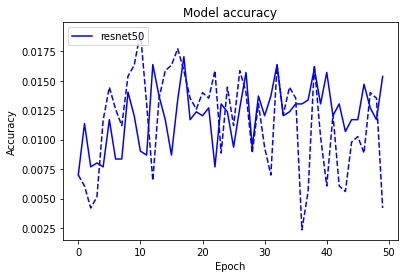

In [16]:
plt.plot(history50.history['accuracy'], 'b')
plt.plot(history50.history['val_accuracy'], 'b--')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet50'], loc='upper left')
plt.show()

optimizer를 SGD로 변경하여 테스트도 진행해 보도록 하겠습니다.

In [17]:
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001,),
    metrics=['accuracy'],)

history50 = resnet50.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
187/187 [==============================] - 48s 227ms/step - loss: 4.7231 - accuracy: 0.0150 - val_loss: 4.7346 - val_accuracy: 0.0131
Epoch 2/50
187/187 [==============================] - 41s 219ms/step - loss: 4.7202 - accuracy: 0.0180 - val_loss: 4.7288 - val_accuracy: 0.0140
Epoch 3/50
187/187 [==============================] - 41s 221ms/step - loss: 4.7238 - accuracy: 0.0207 - val_loss: 4.7351 - val_accuracy: 0.0112
Epoch 4/50
187/187 [==============================] - 41s 220ms/step - loss: 4.7281 - accuracy: 0.0157 - val_loss: 4.7309 - val_accuracy: 0.0112
Epoch 5/50
187/187 [==============================] - 41s 220ms/step - loss: 4.7169 - accuracy: 0.0184 - val_loss: 4.7319 - val_accuracy: 0.0131
Epoch 6/50
187/187 [==============================] - 41s 220ms/step - loss: 4.7208 - accuracy: 0.0140 - val_loss: 4.7291 - val_accuracy: 0.0135
Epoch 7/50
187/187 [==============================] - 41s 221ms/step - loss: 4.7256 - accuracy: 0.0197 - val_loss: 4.7344 - val_ac

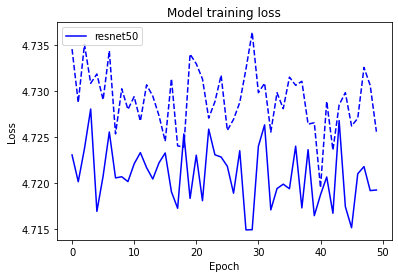

In [18]:
import matplotlib.pyplot as plt
plt.plot(history50.history['loss'], 'b')
plt.plot(history50.history['val_loss'], 'b--')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet50'], loc='upper left')
plt.show()

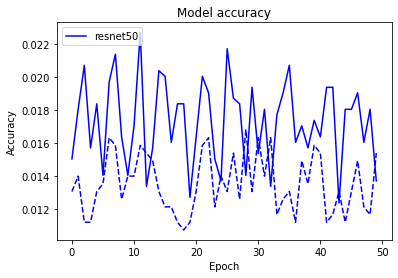

In [19]:
plt.plot(history50.history['accuracy'], 'b')
plt.plot(history50.history['val_accuracy'], 'b--')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet50'], loc='upper left')
plt.show()

## 기본 Augmentation 적용하기

In [8]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00))
    image = tf.image.resize(image, [224, 224])
    return image, label

In [56]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [9]:
num_classes = ds_info.features["label"].num_classes
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [13]:
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test_aug = apply_normalize_on_dataset(ds_test, is_test=True)

In [11]:
EPOCH = 30
BATCH_SIZE = 64

In [14]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(
                                    learning_rate=0.001,
                                    beta_1=0.9,
                                    beta_2=0.999,
                                    epsilon=1e-07,
                                    name='Adam'),
    metrics=['accuracy'],)

history_aug_resnet50 = aug_resnet50.fit(
    ds_train_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test_aug,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
187/187 [==============================] - 47s 202ms/step - loss: 4.8853 - accuracy: 0.0147 - val_loss: 5.4078 - val_accuracy: 0.0112
Epoch 2/30
187/187 [==============================] - 38s 202ms/step - loss: 4.6858 - accuracy: 0.0241 - val_loss: 5.7666 - val_accuracy: 0.0121
Epoch 3/30
187/187 [==============================] - 39s 206ms/step - loss: 4.5724 - accuracy: 0.0291 - val_loss: 4.7656 - val_accuracy: 0.0112
Epoch 4/30
187/187 [==============================] - 39s 209ms/step - loss: 4.4987 - accuracy: 0.0328 - val_loss: 6.6488 - val_accuracy: 0.0112
Epoch 5/30
187/187 [==============================] - 39s 208ms/step - loss: 4.4192 - accuracy: 0.0398 - val_loss: 5.1225 - val_accuracy: 0.0098
Epoch 6/30
187/187 [==============================] - 39s 209ms/step - loss: 4.3647 - accuracy: 0.0424 - val_loss: 4.7242 - val_accuracy: 0.0112
Epoch 7/30
187/187 [==============================] - 39s 209ms/step - loss: 4.2832 - accuracy: 0.0515 - val_loss: 5.8907 - val_ac

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_aug_resnet50.history['loss'], 'b')
plt.plot(history_aug_resnet50.history['val_loss'], 'b--')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['aug_resnet50'], loc='upper left')
plt.show()

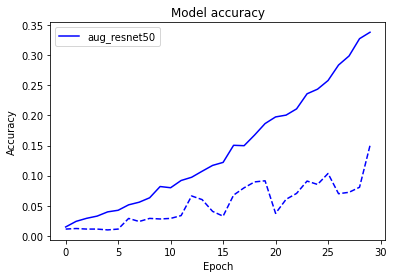

In [15]:
plt.plot(history_aug_resnet50.history['accuracy'], 'b')
plt.plot(history_aug_resnet50.history['val_accuracy'], 'b--')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['aug_resnet50'], loc='upper left')
plt.show()

## Cutmix Augmentation

In [28]:
num_classes = ds_info.features["label"].num_classes

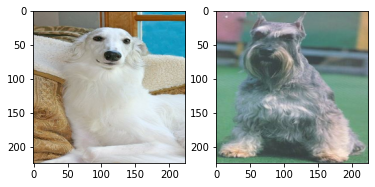

In [21]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_norm.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [22]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(160, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)
y :  tf.Tensor(194, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


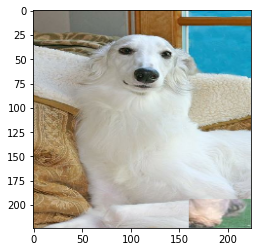

In [23]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

In [24]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.9617347 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.03826531, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [25]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

## Mixup Augmentation

In [26]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

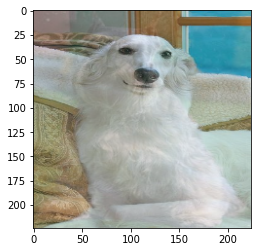

In [29]:
mixed_img2, mixed_label2 = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img2.numpy())
plt.show()

In [30]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

## Cutmix / Mixup 비교하기

In [7]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )    
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )

    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )

    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

    return ds

In [32]:
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)

In [33]:
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)

In [36]:
ds_test = apply_normalize_on_dataset(ds_test)

In [34]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(120, activation='softmax')
])

94781440/94765736 [==============================] - 1s 0us/step


In [37]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(
                                    learning_rate=0.001,
                                    beta_1=0.9,
                                    beta_2=0.999,
                                    epsilon=1e-07,
                                    name='Adam'),
    metrics=['accuracy'],)

history_cutmix_resnet50 = cutmix_resnet50.fit(
    ds_train_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
187/187 [==============================] - 50s 221ms/step - loss: 4.8624 - accuracy: 0.0070 - val_loss: 4.8284 - val_accuracy: 0.0075
Epoch 2/30
187/187 [==============================] - 41s 219ms/step - loss: 4.7972 - accuracy: 0.0110 - val_loss: 4.8178 - val_accuracy: 0.0065
Epoch 3/30
187/187 [==============================] - 42s 223ms/step - loss: 4.7998 - accuracy: 0.0087 - val_loss: 4.8032 - val_accuracy: 0.0121
Epoch 4/30
187/187 [==============================] - 42s 225ms/step - loss: 4.8024 - accuracy: 0.0084 - val_loss: 4.8799 - val_accuracy: 0.0075
Epoch 5/30
187/187 [==============================] - 42s 224ms/step - loss: 4.8302 - accuracy: 0.0084 - val_loss: 5.2579 - val_accuracy: 0.0107
Epoch 6/30
187/187 [==============================] - 42s 225ms/step - loss: 4.7994 - accuracy: 0.0087 - val_loss: 4.7934 - val_accuracy: 0.0061
Epoch 7/30
187/187 [==============================] - 42s 225ms/step - loss: 4.8042 - accuracy: 0.0090 - val_loss: 4.8218 - val_ac

In [39]:
df_cutmix_resnet50 = pd.DataFrame({
    'train_loss': history_cutmix_resnet50.history['loss'],
    'train_acc': history_cutmix_resnet50.history['accuracy'],
    'val_loss': history_cutmix_resnet50.history['val_loss'],
    'val_acc': history_cutmix_resnet50.history['val_accuracy']
    })
df_cutmix_resnet50.to_csv('./history/history_cutmix_resnet50.csv', index=False)

In [38]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(120, activation='softmax')
])

In [40]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(
                                    learning_rate=0.001,
                                    beta_1=0.9,
                                    beta_2=0.999,
                                    epsilon=1e-07,
                                    name='Adam'),
    metrics=['accuracy'],)

history_mixup_resnet50 = mixup_resnet50.fit(
    ds_train_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
187/187 [==============================] - 51s 231ms/step - loss: 4.9280 - accuracy: 0.0084 - val_loss: 14.8761 - val_accuracy: 0.0051
Epoch 2/30
187/187 [==============================] - 42s 225ms/step - loss: 4.8134 - accuracy: 0.0074 - val_loss: 4.7872 - val_accuracy: 0.0051
Epoch 3/30
187/187 [==============================] - 42s 225ms/step - loss: 4.7969 - accuracy: 0.0097 - val_loss: 4.7882 - val_accuracy: 0.0093
Epoch 4/30
187/187 [==============================] - 42s 225ms/step - loss: 4.8002 - accuracy: 0.0053 - val_loss: 4.7846 - val_accuracy: 0.0093
Epoch 5/30
187/187 [==============================] - 42s 225ms/step - loss: 4.8063 - accuracy: 0.0094 - val_loss: 4.9007 - val_accuracy: 0.0079
Epoch 6/30
187/187 [==============================] - 42s 224ms/step - loss: 4.8148 - accuracy: 0.0127 - val_loss: 4.8839 - val_accuracy: 0.0126
Epoch 7/30
187/187 [==============================] - 42s 225ms/step - loss: 4.7844 - accuracy: 0.0120 - val_loss: 5.1892 - val_a

In [41]:
df_mixup_resnet50 = pd.DataFrame({
    'train_loss': history_mixup_resnet50.history['loss'],
    'train_acc': history_mixup_resnet50.history['accuracy'],
    'val_loss': history_mixup_resnet50.history['val_loss'],
    'val_acc': history_mixup_resnet50.history['val_accuracy']
    })
df_mixup_resnet50.to_csv('./history/history_mixup_resnet50.csv', index=False)

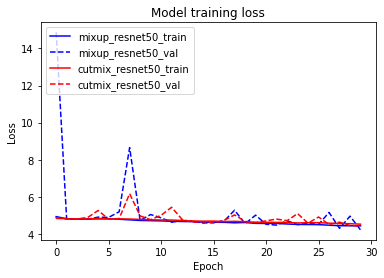

In [48]:
import matplotlib.pyplot as plt
plt.plot(history_mixup_resnet50.history['loss'], 'b')
plt.plot(history_mixup_resnet50.history['val_loss'], 'b--')
plt.plot(history_cutmix_resnet50.history['loss'], 'r')
plt.plot(history_cutmix_resnet50.history['val_loss'], 'r--')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['mixup_resnet50_train','mixup_resnet50_val','cutmix_resnet50_train', 'cutmix_resnet50_val'], loc='upper left')
plt.show()

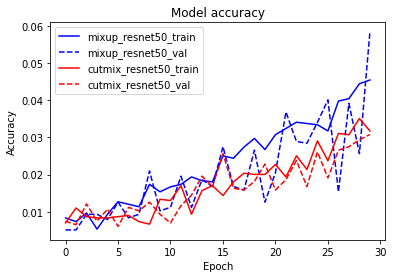

In [49]:
plt.plot(history_mixup_resnet50.history['accuracy'], 'b')
plt.plot(history_mixup_resnet50.history['val_accuracy'], 'b--')
plt.plot(history_cutmix_resnet50.history['accuracy'], 'r')
plt.plot(history_cutmix_resnet50.history['val_accuracy'], 'r--')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['mixup_resnet50_train','mixup_resnet50_val','cutmix_resnet50_train', 'cutmix_resnet50_val'], loc='upper left')
plt.show()

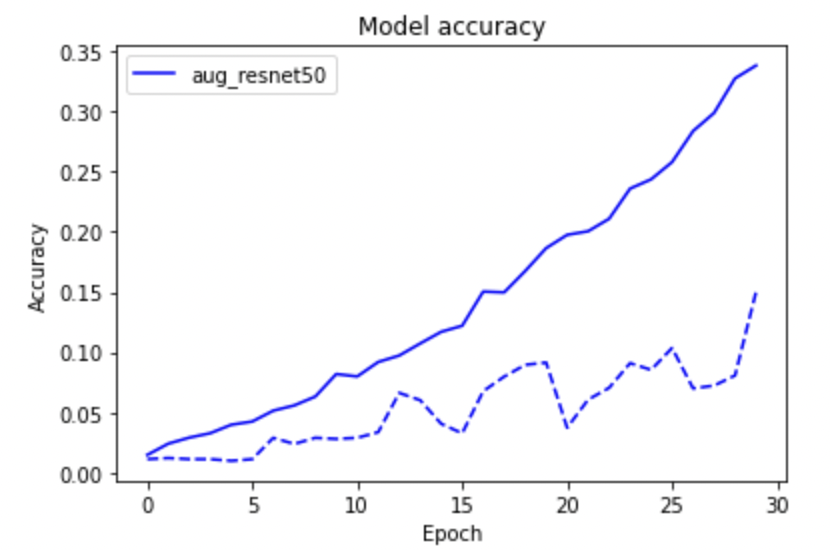

## 회고  
- 이전 프로젝트에서 자체 구축한 resnet50 모델을 통해 데이터 셋만 변경하여 학습을 수행했으나, 여전히 좋은 결과를 얻지 못하여 모델 자체 점검을 전체적으로 다시 수행해 보는 것이 좋겠습니다.    
- 기본 augmentation과 augmentation 없이 학습을 수행한 결과 여전히 training set만 학습이 진행되고 test set에 대해서는 좋은 결과값을 얻지 못했습니다.  
- 정확도가 높지 않지만 추가적인 테스트 및 검증이 필요할 것으로 판단되나, 현재 결과로는 mixup > 기본 augmentation > cutmix 순으로 정확도가 나왔습니다.   
- stanford dogs 데이터셋에 대한 리더보드 히스토리를 본 결과 비교적 최근까지 accuracy가 높지 않은 것을 보아 일반적인 방법으로 높은 accuracy 결과를 가져오기는 힘들 것으로 예상됩니다.  
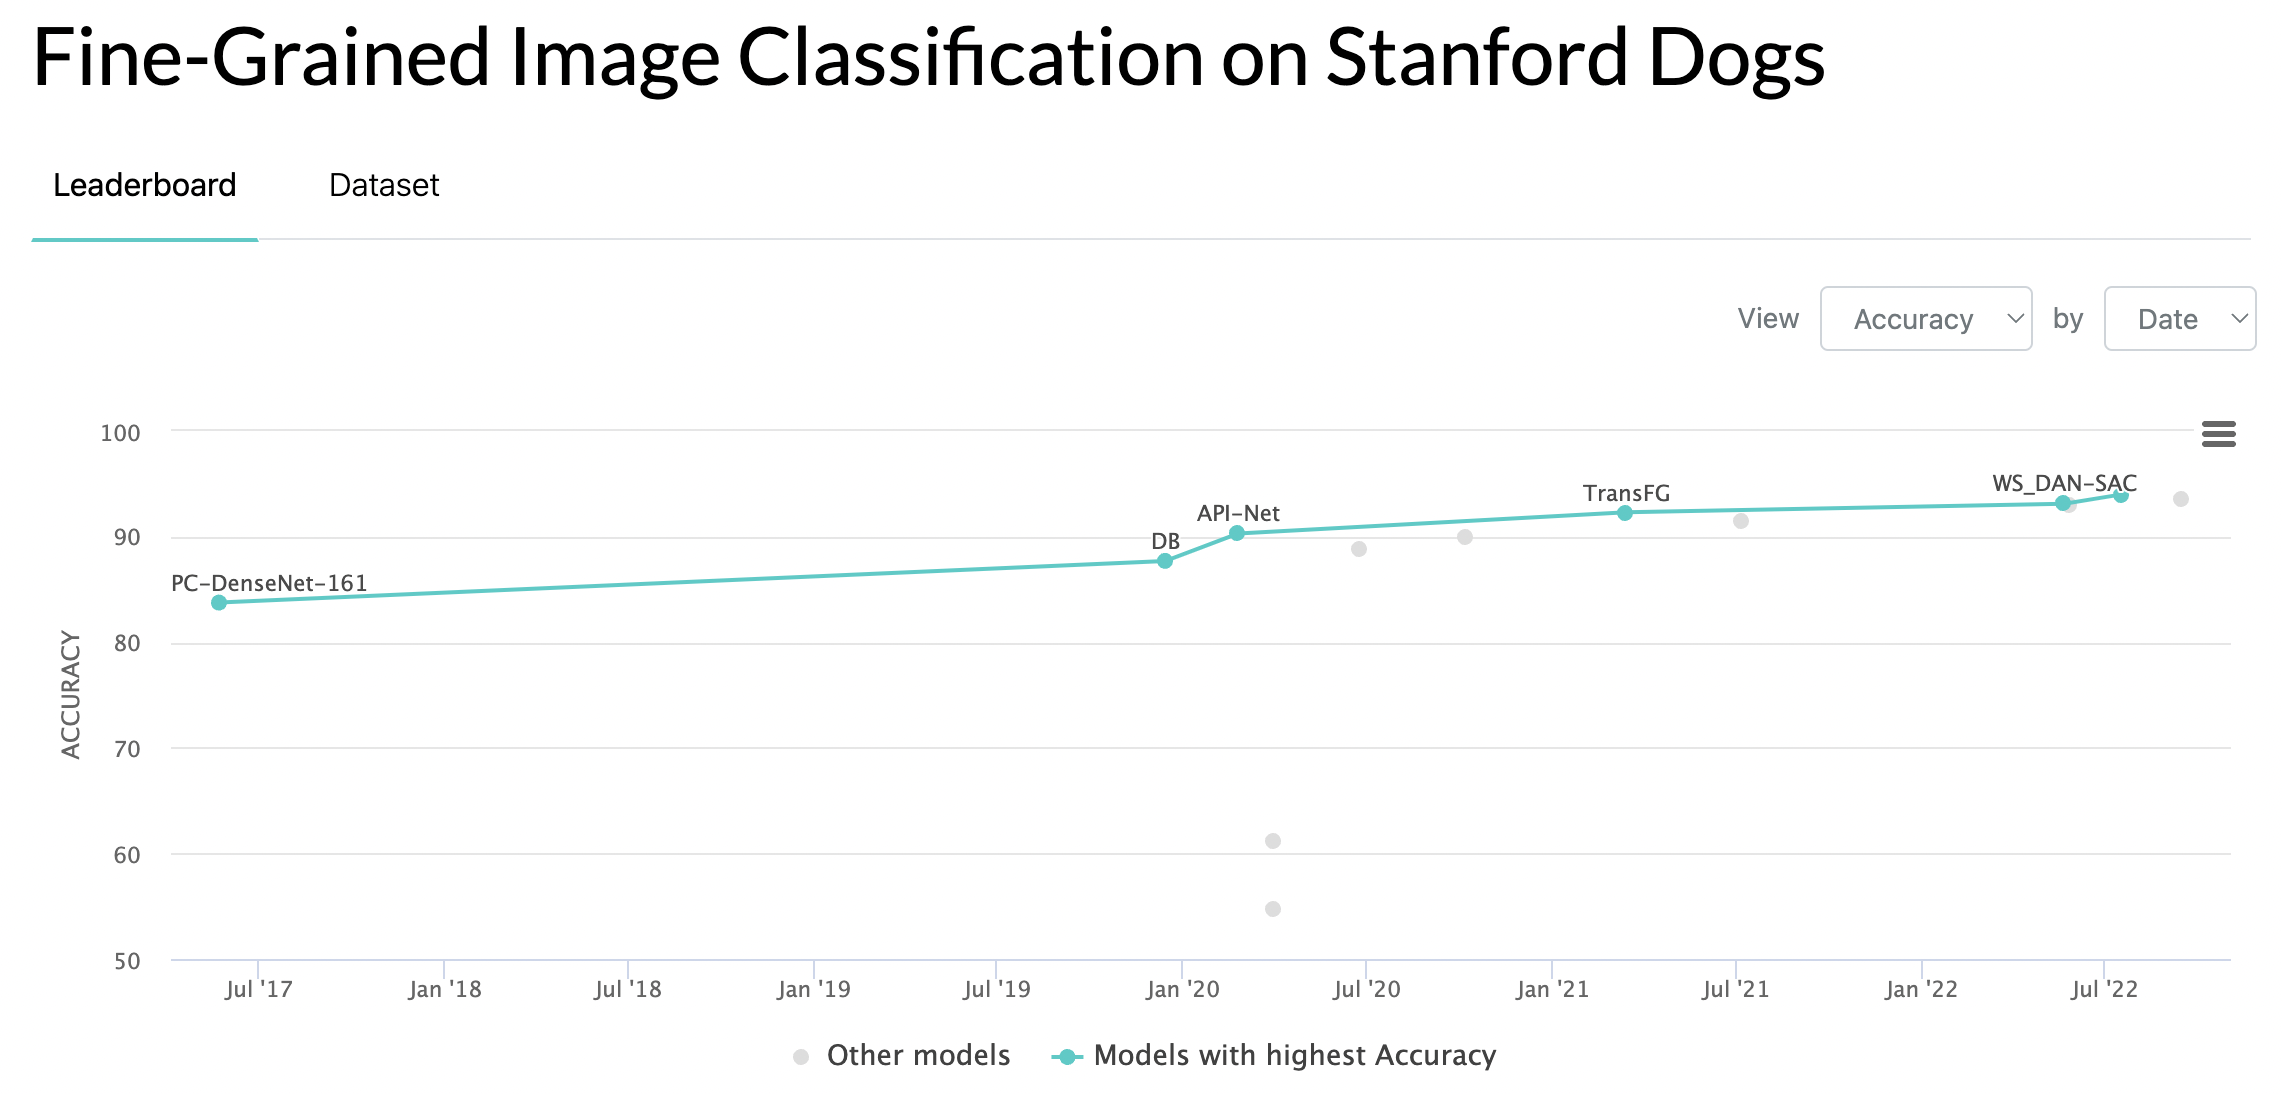  


[참고]  
- https://github.com/aeolian83/aiffel_mini_prject/blob/main/Going_deeper04_data_augmentation2/data_augmentation_1.ipynb  